## Импорты и настройки

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)

%matplotlib inline
sns.set(style="whitegrid")


c:\Users\Zver\AppData\Local\Programs\Python\Python310\lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Zver\AppData\Local\Programs\Python\Python310\lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Zver\AppData\Local\Programs\Python\Python310\lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/

## Загрузка классов и модели

In [2]:
MODEL_PATH = "models/butterfly_model_best.h5"
DATASET_PATH = "dataset"
IMG_SIZE = 224
BATCH_SIZE = 32

# классы
with open("models/classes.json") as f:
    CLASSES = json.load(f)

# модель
model = tf.keras.models.load_model(MODEL_PATH)

print("Classes:", CLASSES)


Classes: ['Apoda_limacodes', 'Hyphantria_cunea', 'Orosanga_japonicus', 'Heterogenea_asella', 'Aglais_io', 'Vanessa_atalanta', 'Papilio_machaon']


## Анализ распределения датасета

In [3]:
class_counts = {}

for cls in CLASSES:
    class_dir = os.path.join(DATASET_PATH, cls)
    # считаем все файлы, игнорируем только скрытые
    images = [f for f in os.listdir(class_dir)]
    class_counts[cls] = len(images)

df_counts = pd.DataFrame.from_dict(
    class_counts, orient="index", columns=["count"]
).reset_index().rename(columns={"index": "class"})

df_counts


,class,count
0,Apoda_limacodes,3544
1,Hyphantria_cunea,2058
2,Orosanga_japonicus,603
3,Heterogenea_asella,238
4,Aglais_io,30
5,Vanessa_atalanta,28
6,Papilio_machaon,28


## Визуализация распределения

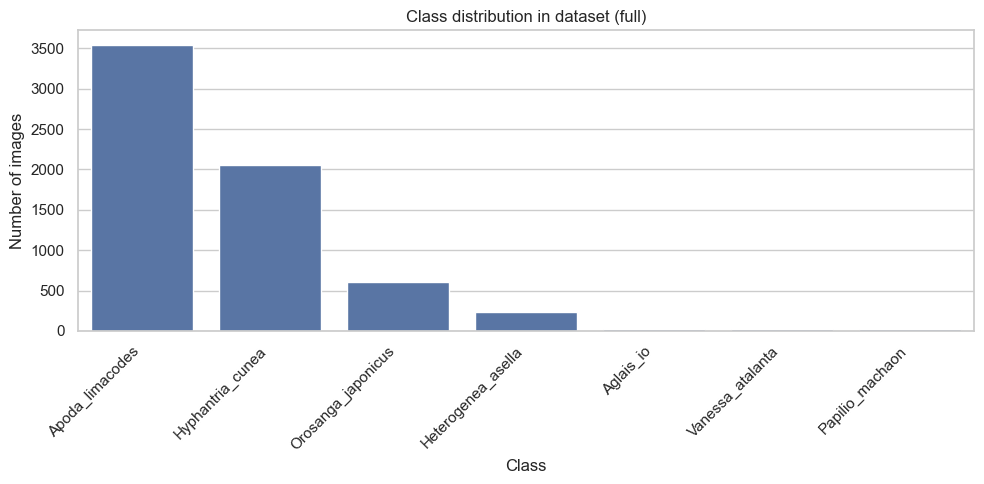

In [4]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df_counts, x="class", y="count")
plt.xticks(rotation=45, ha="right")
plt.title("Class distribution in dataset (full)")
plt.ylabel("Number of images")
plt.xlabel("Class")
plt.tight_layout()
plt.show()

## Автоматическое разбиение на test

In [5]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2   # 20% данных → test
)

test_generator = test_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",   # берём именно test
    shuffle=False
)

print("Class indices:", test_generator.class_indices)


Found 1302 images belonging to 7 classes.
Class indices: {'Aglais_io': 0, 'Apoda_limacodes': 1, 'Heterogenea_asella': 2, 'Hyphantria_cunea': 3, 'Orosanga_japonicus': 4, 'Papilio_machaon': 5, 'Vanessa_atalanta': 6}


## Предсказания модели

In [6]:
y_true = test_generator.classes

y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)


41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 417ms/step


## Общая точность на test

In [7]:
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test accuracy: {test_accuracy:.4f}")


Test accuracy: 0.8710


## Метрики по каждому классу

In [8]:
from sklearn.metrics import classification_report

report = classification_report(
    y_true,
    y_pred,
    target_names=CLASSES,
    output_dict=True
)

df_report = (
    pd.DataFrame(report)
    .transpose()
    .loc[CLASSES]
)

df_report[["precision", "recall", "f1-score", "support"]]


,precision,recall,f1-score,support
Apoda_limacodes,0.714286,0.833333,0.769231,6.0
Hyphantria_cunea,0.980132,0.836158,0.902439,708.0
Orosanga_japonicus,0.293233,0.829787,0.433333,47.0
Heterogenea_asella,0.902050,0.963504,0.931765,411.0
Aglais_io,0.859813,0.766667,0.810573,120.0
Vanessa_atalanta,0.833333,1.000000,0.909091,5.0
Papilio_machaon,0.833333,1.000000,0.909091,5.0


## Confusion Matrix

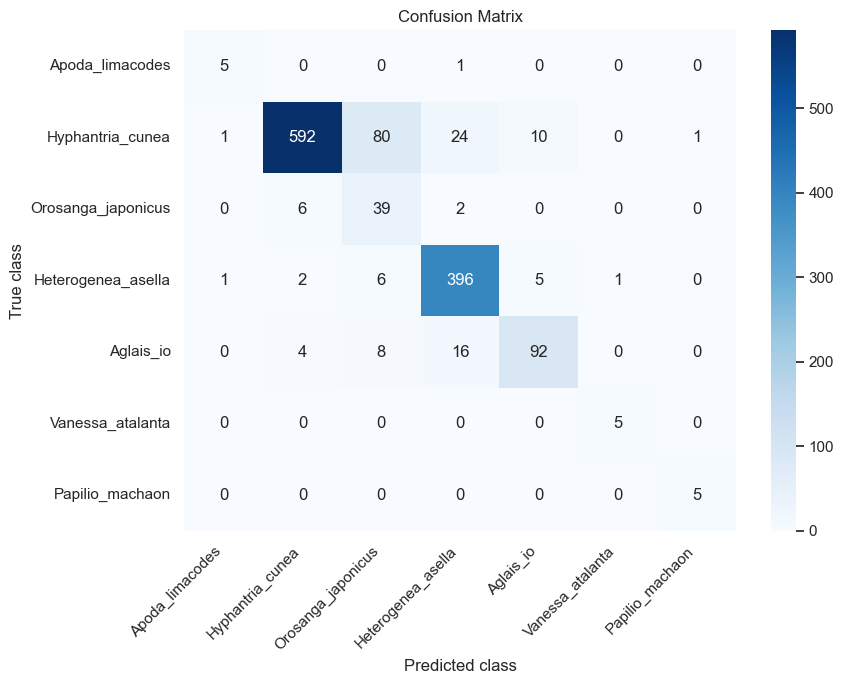

In [9]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(9, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASSES,
    yticklabels=CLASSES
)
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
